# Preliminary Simulation Analysis

In [11]:
import numpy as np
import h5py
import swiftsimio as sw
import matplotlib.pyplot as plt

In [12]:
# Function to read in halo properties
def loadProperties(catalogue):
    soap = h5py.File(catalogue, 'r') # Read in SOAP property file
    mtotal = np.array(soap['BoundSubhaloProperties/TotalMass']) # Not m200 anymore
    mstar = np.array(soap['ExclusiveSphere/30kpc/StellarMass'])

    # If you want to mask for field haloes only (host halos only)
    #field = np.array(soap['VR/HostHaloID']) #all satellites have a host halo id that points towards the satellite
    #m200 = m200[field==-1]
    #mstar = mstar[field==-1]

    return mtotal, mstar

# function to read in bound DM particles for a given halo
def getHaloDarkMatterMembers(snapshot, membership_file, halo_index):
    members = h5py.File(membership_file, 'r') # Membership data
    host_halo_ids = np.array(members['PartType1/GroupNr_bound']) # Gives the host halo ID that each particle is bound to
    bound_particles = np.where(host_halo_ids == halo_index) # Find index of particles bound to given halo

    data = sw.load(snapshot) # Load snapshot data
    positions = data.dark_matter.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
    positions = positions[bound_particles] # Mask for particles bound to given halo

    return positions

def getHaloStarsMembers(snapshot, membership_file, halo_index):
    members = h5py.File(membership_file, 'r') # Membership data
    host_halo_ids = np.array(members['PartType4/GroupNr_bound']) # Gives the host halo ID that each particle is bound to
    bound_particles = np.where(host_halo_ids == halo_index) # Find index of particles bound to given halo

    data = sw.load(snapshot) # Load snapshot data
    positions = data.stars.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
    positions = positions[bound_particles] # Mask for particles bound to given halo

    return positions

## Get general properties

In [13]:
SOAP_fname = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/SOAP_halo_properties_0063.hdf5'
SOAP_membership = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/SOAP_membership_0063.hdf5'
snapshot = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/snapshot_0063.hdf5'
halo = 5 # Example

soap = h5py.File(SOAP_fname, 'r') # Read in SOAP property file
members = h5py.File(SOAP_membership, 'r')
mtotal, mstar = loadProperties(SOAP_fname)
stars_positions = getHaloStarsMembers(snapshot, SOAP_membership, halo)
field = np.array(soap['VR/HostHaloID'])

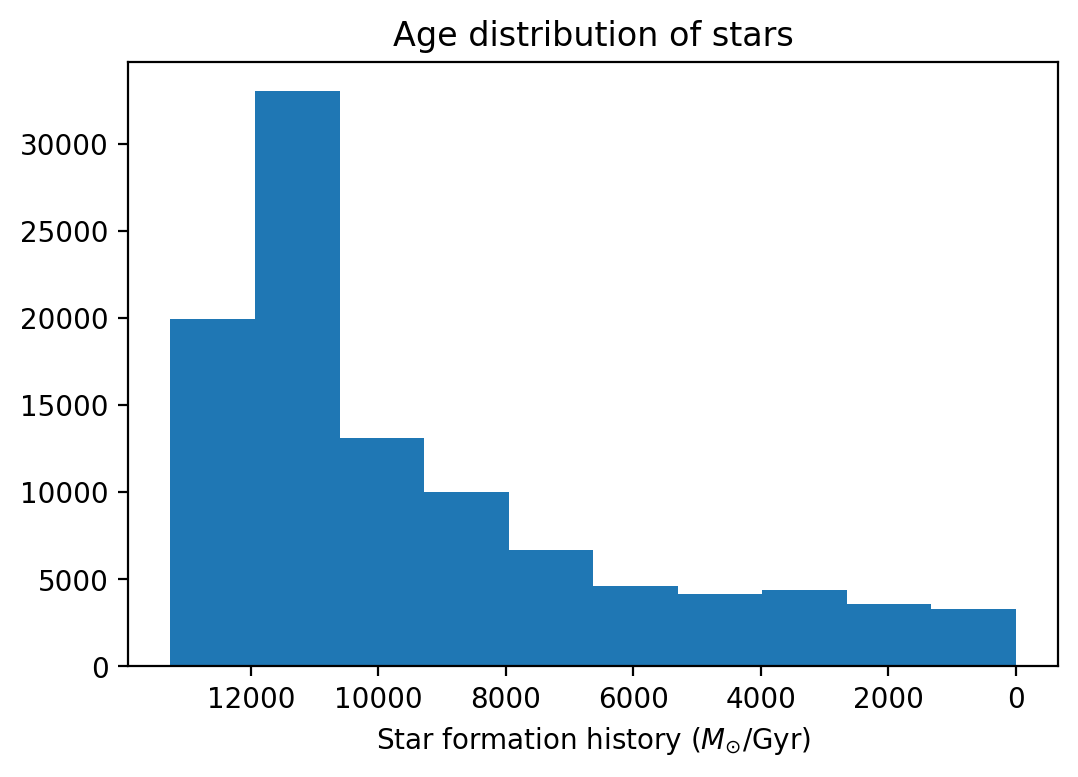

In [14]:
data = sw.load(snapshot)
#print(data.metadata.stars_properties.field_names)
time = np.cumsum(data.stars.timestep*977.79) #Gyr comoving
birth_scale_factor = data.stars.birth_scale_factors
plt.figure(dpi=200)
mass = np.array(data.stars.masses*10000000000.0)
age = np.array(data.stars.ages*977.79)
dmdt = mass/age
plt.hist(age) #convert to stellar mass by time instead of number by scale factor
#plt.scatter(masses, age, s = 1, alpha = 0.01)
plt.xlabel(r'Star formation history ($M_{\odot}$/Gyr)')
#plt.xscale('log')
plt.gca().invert_xaxis()
plt.title('Age distribution of stars')
plt.show()

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


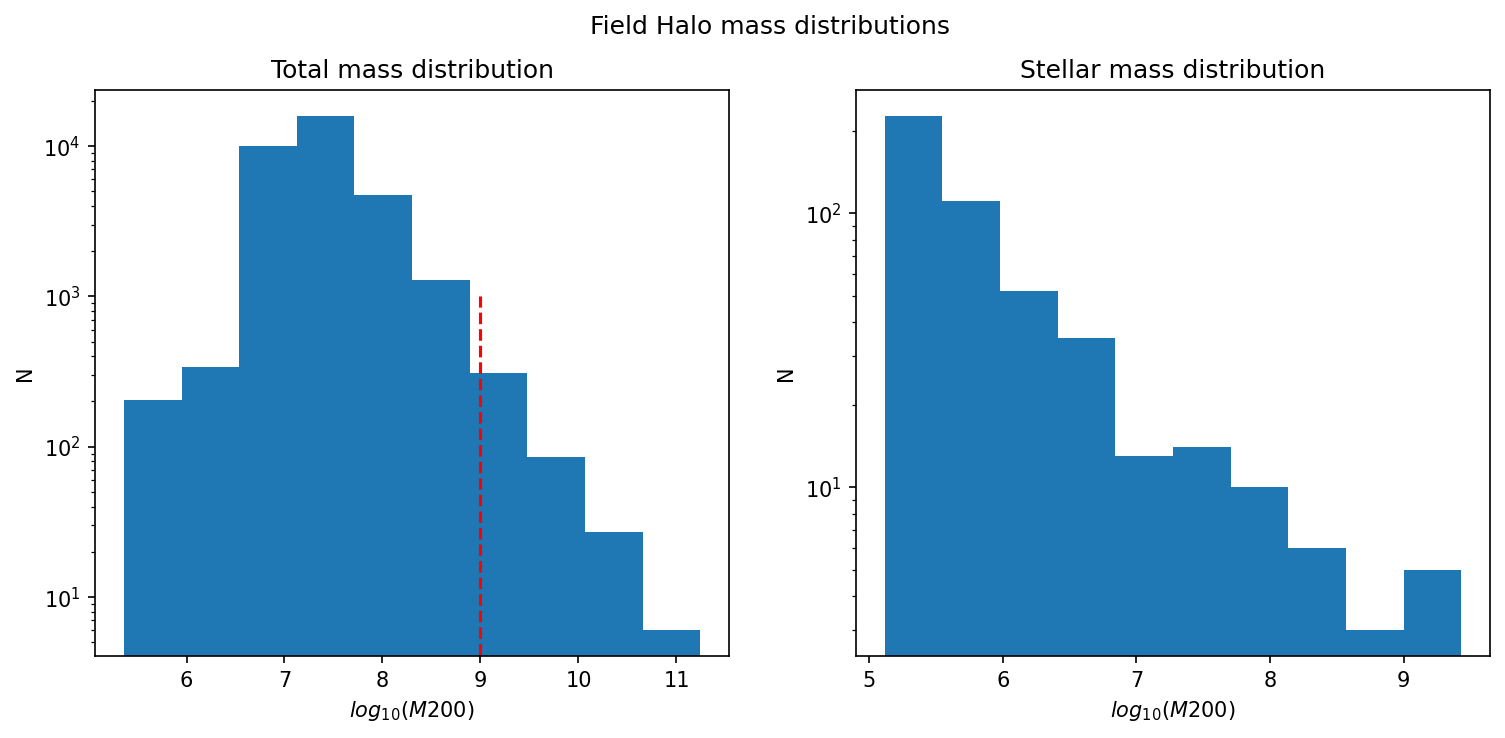

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=150)
axs[0].hist(np.log10(np.ma.array(mtotal[field==-1])))
axs[1].hist(np.log10(np.ma.array(mstar[field==-1])))
for ax in axs: 
    ax.set_ylabel('N')
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_xlabel(r'$log_{10}(M200)$')
axs[0].set_title('Total mass distribution')
axs[1].set_title('Stellar mass distribution')
axs[0].vlines(9, 0, 1e3, 'r','--')
fig.suptitle('Field Halo mass distributions')
fig.show() 

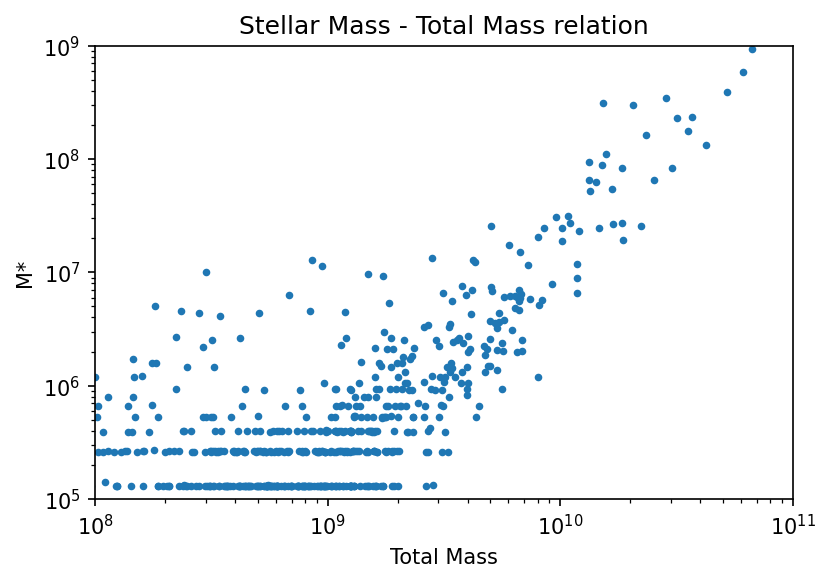

In [16]:
sorted_idx = np.argsort(mstar)
fig, ax = plt.subplots(dpi=150)
ax.scatter(mtotal[sorted_idx], mstar[sorted_idx], s = 7)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Total Mass')
ax.set_ylabel('M*')
ax.set_ylim(1e5,1e9)
ax.set_xlim(1e8,1e11)
ax.set_title('Stellar Mass - Total Mass relation')
fig.show()
#everything in solar masses
#horizontal lines are single particles/2 particles
#LMC is 10^9 stellar mass

In [17]:
data = sw.load(snapshot) #read final snapshot
pos = data.dark_matter.coordinates

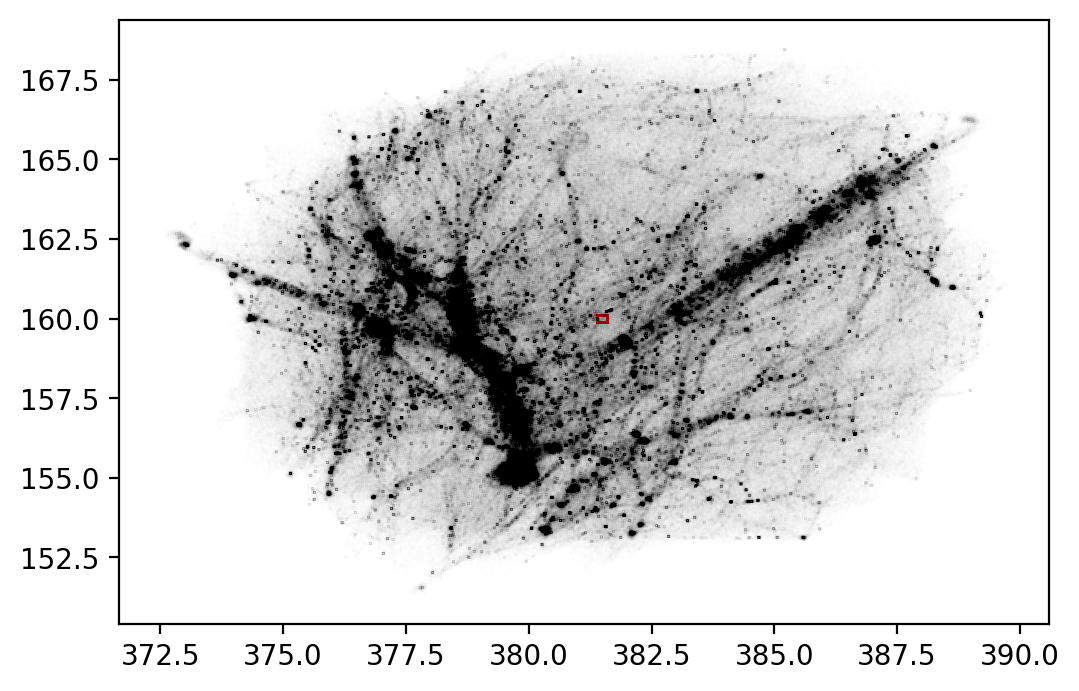

In [18]:
plt.figure(dpi=200)
plt.plot(pos[::10,0], pos[::10,2],'k.', markersize=0.25, alpha=0.01)
side_length = 0.20
center_x = 381.5
center_y = 160
# Calculate the bottom left corner of the square
bottom_left_x = center_x - side_length / 2
bottom_left_y = center_y - side_length / 2

# Create the square box
square_box = plt.Rectangle((bottom_left_x, bottom_left_y), side_length, side_length, edgecolor='r', facecolor='none')

# Add the square box to the plot
plt.gca().add_patch(square_box)
plt.show()

## Get DM Halo particles
Also gets halo IDs

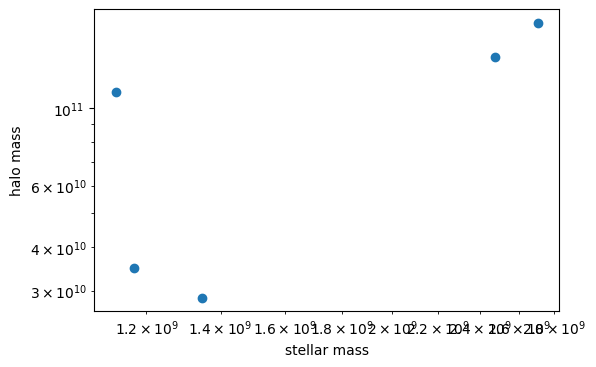

In [19]:
halo_ids = soap['VR/ID']
host_halo_ids = np.array(soap['VR/ID'])[field==-1]
idx = mstar[field==-1]>1e9
massive_halo_ids = host_halo_ids[idx]-1 #this way of selecting is not working
plt.figure(dpi=100)
plt.scatter(mstar[massive_halo_ids], mtotal[massive_halo_ids])
plt.xlabel('stellar mass')
plt.ylabel('halo mass')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [20]:
centers = np.array(soap['VR/CentreOfPotential'])[massive_halo_ids]
central_massive_halo_centers = []
central_massive_halo_ids = []
for i, center in enumerate(centers):
    #382.208, 57.656, 160.808
    #don't hard code
    if 377 <= center[0] <= 387 and 52 <= center[1] <= 62 and 155 <= center[2] <= 165:
        central_massive_halo_centers.append(center)
        central_massive_halo_ids.append(massive_halo_ids[i]+1)
central_massive_halo_centers = np.array(central_massive_halo_centers)
central_massive_halo_ids = np.array(central_massive_halo_ids) - 1
print(central_massive_halo_ids)

[ 2.  3. 10.]


## Plot particle distributions

In [24]:
def plot_particles(which_host):
    sat_ids = halo_ids[field==massive_halo_ids[which_host]]
    print('Number of satellites', len(sat_ids))
    host_halo_part = getHaloDarkMatterMembers(snapshot, SOAP_membership, massive_halo_ids[which_host])
    host_star_part = getHaloStarsMembers(snapshot, SOAP_membership, massive_halo_ids[which_host])
    sat_halo_part = []
    sat_star_part = []
    for i in sat_ids:
        sat_halo_part.append(getHaloDarkMatterMembers(snapshot, SOAP_membership, i))
        sat_star_part.append(getHaloStarsMembers(snapshot, SOAP_membership, i))    
    sat_halo_part = np.array(sat_halo_part)
    sat_star_part = np.array(sat_star_part)
    fig, ax = plt.subplots(1, 2, dpi=200, figsize = (12,7))
    ax[0].scatter(host_halo_part[::10,0], host_halo_part[::10,1], s=1, alpha = 0.2, c='black')
    ax[1].scatter(host_star_part[::10,0], host_star_part[::10,1], s=1, alpha = 0.2, c='black')
    #for sat in np.array(sat_star_part)[np.arange(len(sat_star_part))!=5]:
    for sat in sat_halo_part: #-4
        ax[0].scatter(sat[::10,0], sat[::10,1], s=1, alpha=0.2, c='red')
    for sat in sat_star_part: #-4
        ax[1].scatter(sat[::10,0], sat[::10,1], s=1, alpha=0.2, c='red')
    ax[1].set_title(f'Star particles of halo {which_host+1} and satellites')
    ax[0].set_title(f'Dark matter particles of halo {which_host+1} and satellites')
    fig.show()

In [ ]:
def read_particles(which_host):
    sat_ids = halo_ids[field==massive_halo_ids[which_host]]
    #print(field[field==massive_halo_ids[which_host]])
    print('Number of satellites', len(sat_ids))
    host_halo_part = getHaloDarkMatterMembers(snapshot, SOAP_membership, which_host)
    host_star_part = getHaloStarsMembers(snapshot, SOAP_membership, which_host)
    sat_halo_part = []
    sat_star_part = []
    for i in sat_ids:
        sat_halo_part.append(getHaloDarkMatterMembers(snapshot, SOAP_membership, i))
        sat_star_part.append(getHaloStarsMembers(snapshot, SOAP_membership, i))
    sat_halo_part = np.array(sat_halo_part)
    sat_star_part = np.array(sat_star_part)
    return host_halo_part, host_star_part, sat_halo_part, sat_star_part, sat_ids

host_halo_part, host_star_part, sat_halo_part, sat_star_part, sat_ids = read_particles(1)

Number of satellites 138


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [147]:
def plot_hist_halos(host_halo_part, host_star_part, sat_halo_part, sat_star_part):
    #make host halo histogram
    host_halo_hist, host_halo_yedges, host_halo_xedges = np.histogram2d(host_halo_part[:,1], host_halo_part[:,0], bins=500)
    host_halo_H = np.where(host_halo_hist != 0, np.log(host_halo_hist), 1)
    
    #make host stars histogram
    host_star_hist, host_star_yedges, host_star_xedges = np.histogram2d(host_star_part[:,1], host_star_part[:,0], bins=500)
    host_star_H = np.where(host_star_hist != 0, np.log(host_star_hist), 1)
    
    #make satellite halo histogram
    sat_halo_hist, sat_halo_yedges, sat_halo_xedges = np.histogram2d(sat_halo_part[:,1], sat_halo_part[:,0], bins=500)
    sat_halo_H = np.where(sat_halo_hist != 0, np.log(sat_halo_hist), 1)
    
    #make satellite halo histogram
    sat_star_hist, sat_star_yedges, sat_star_xedges = np.histogram2d(sat_star_part[:,1], sat_star_part[:,0], bins=500)
    sat_star_H = np.where(sat_star_hist != 0, np.log(sat_star_hist), 1)    
    
    #arepo_H, arepo_yedges, arepo_xedges = np.histogram2d(coord_dm[:,1], coord_dm[:,0], bins=300)
    fig, ax = plt.subplots(1, 2, dpi=200, figsize = (12,7))
    im1 = ax[0].imshow(host_halo_H, origin='lower', cmap = 'magma')
    im1 = ax[0].imshow(sat_halo_H, origin='lower', cmap = 'magma')
    ax[1].imshow(host_star_H, origin='lower', cmap = 'magma')
    ax[1].imshow(sat_star_H, origin='lower', cmap = 'magma')
    #for a in ax:
        #a.set_xlim(200, 300)
        #a.set_ylim(200, 300)
    for sat in sat_halo_part: #-4
        ax[0].scatter(sat[:,1], sat[:,2], s=1, alpha=0.2, c='red')
    for sat in sat_star_part: #-4
        ax[1].scatter(sat[:,1], sat[:,2], s=1, alpha=0.2, c='red')
    
    #fig.colorbar(im1)
    ax[1].set_title(f'Star particles of halo and satellites')
    ax[0].set_title(f'Dark matter particles of halo and satellites')
    fig.show()

In [ ]:
#sat_halo_part
plot_hist_halos(host_halo_part, host_star_part, sat_halo_part, sat_star_part)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Number of satellites 138
Number of satellites 153


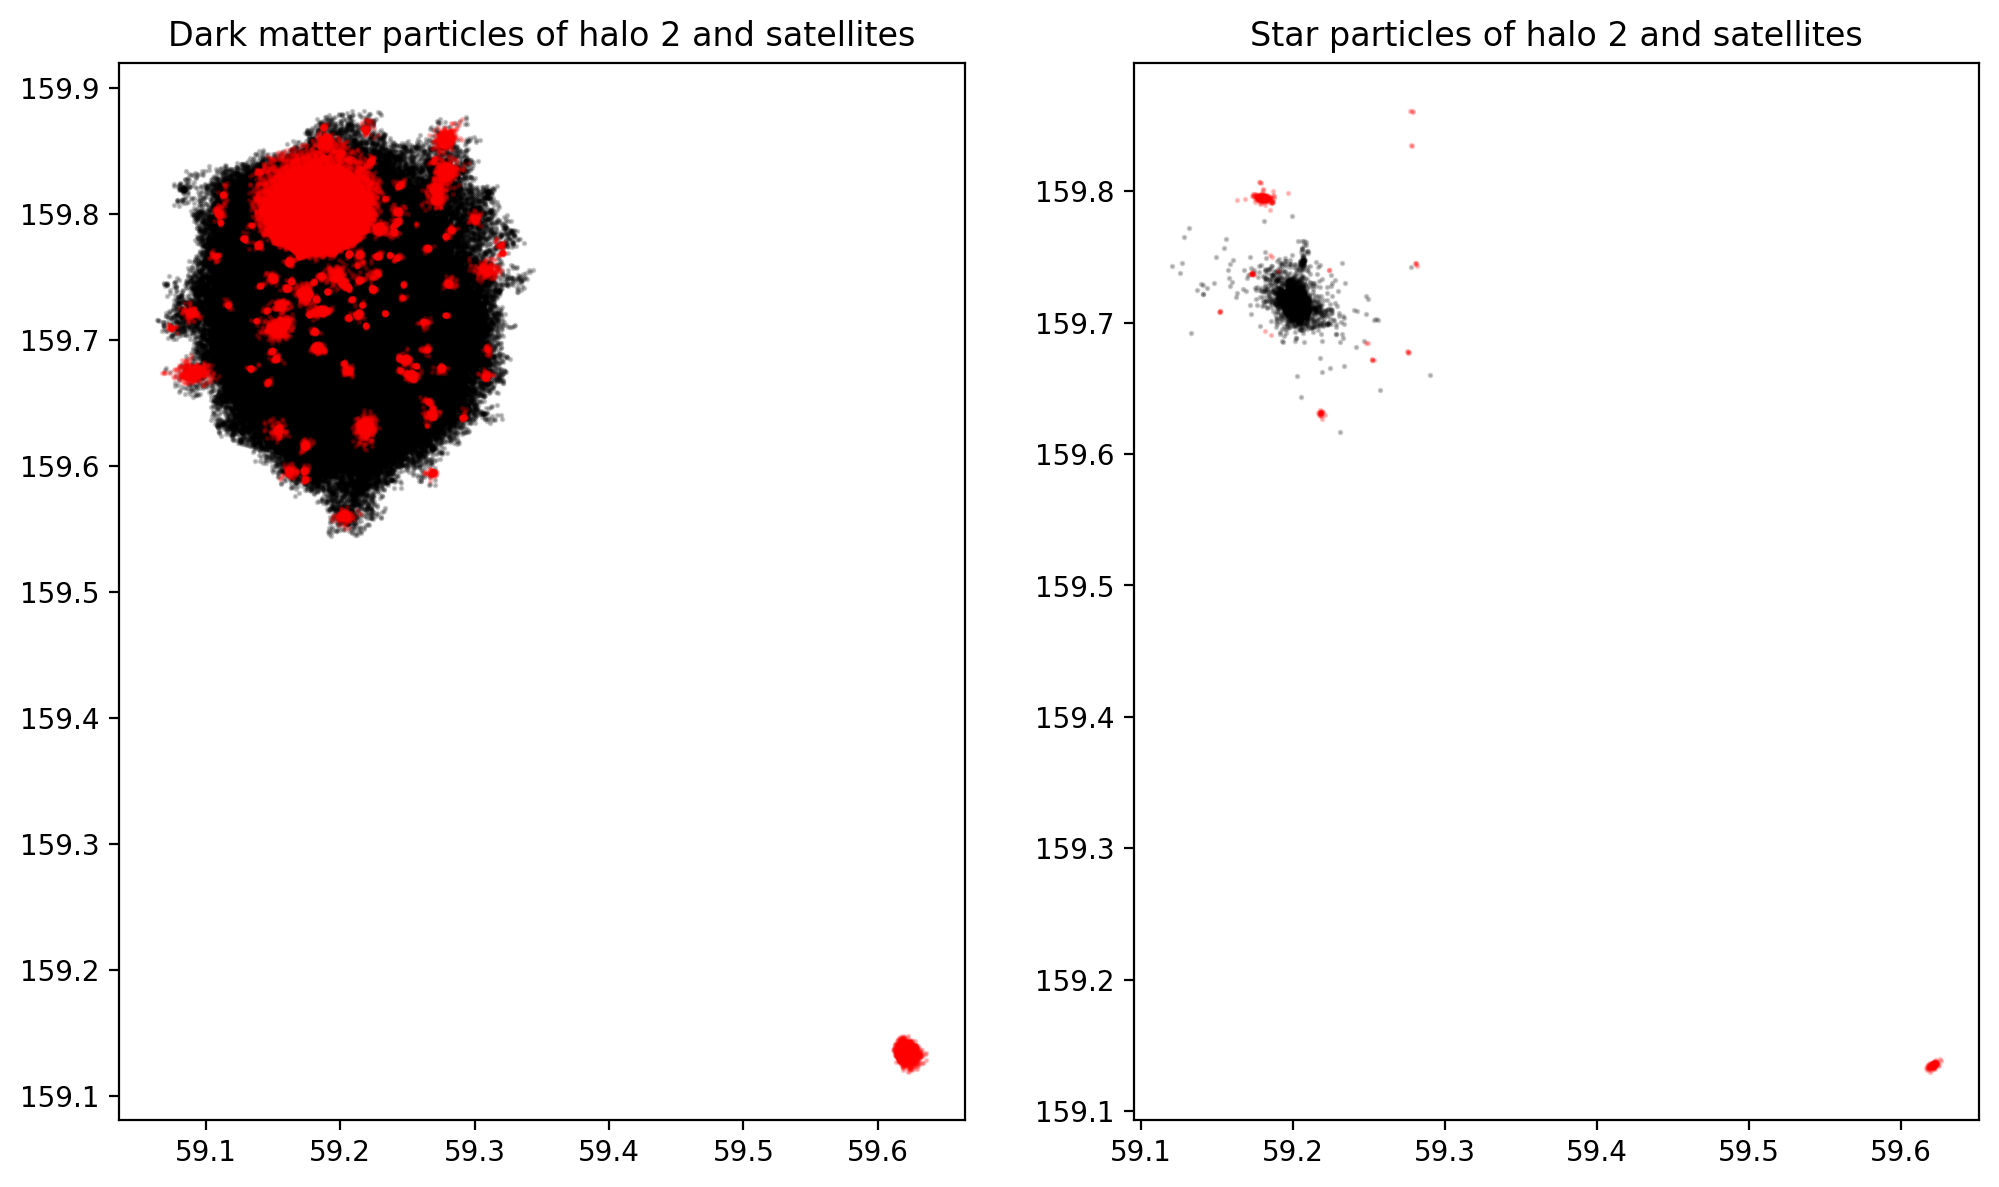

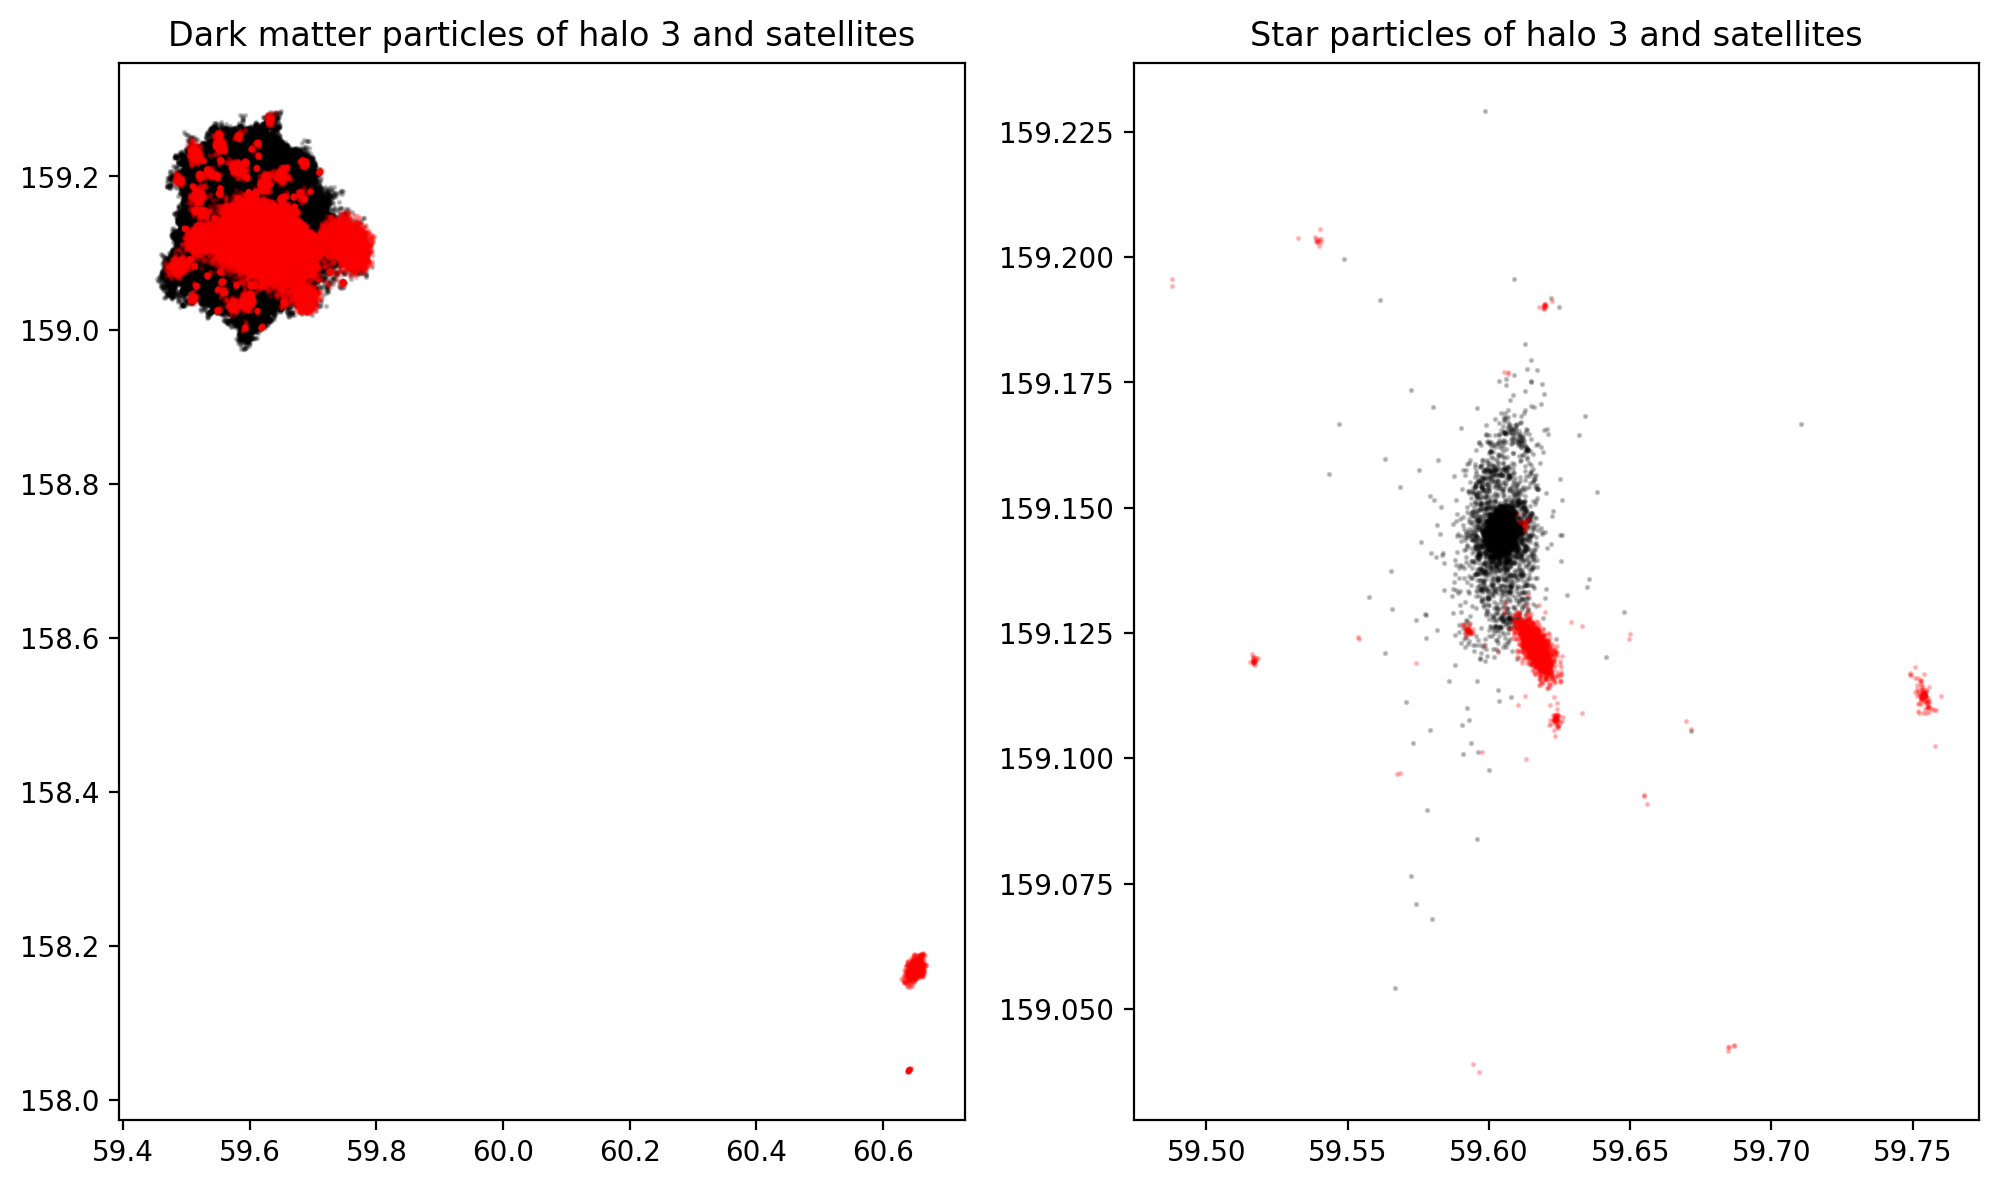

In [24]:
plot_particles(1) #can change to 2D histogram?
plot_particles(2)

Number of satellites 162


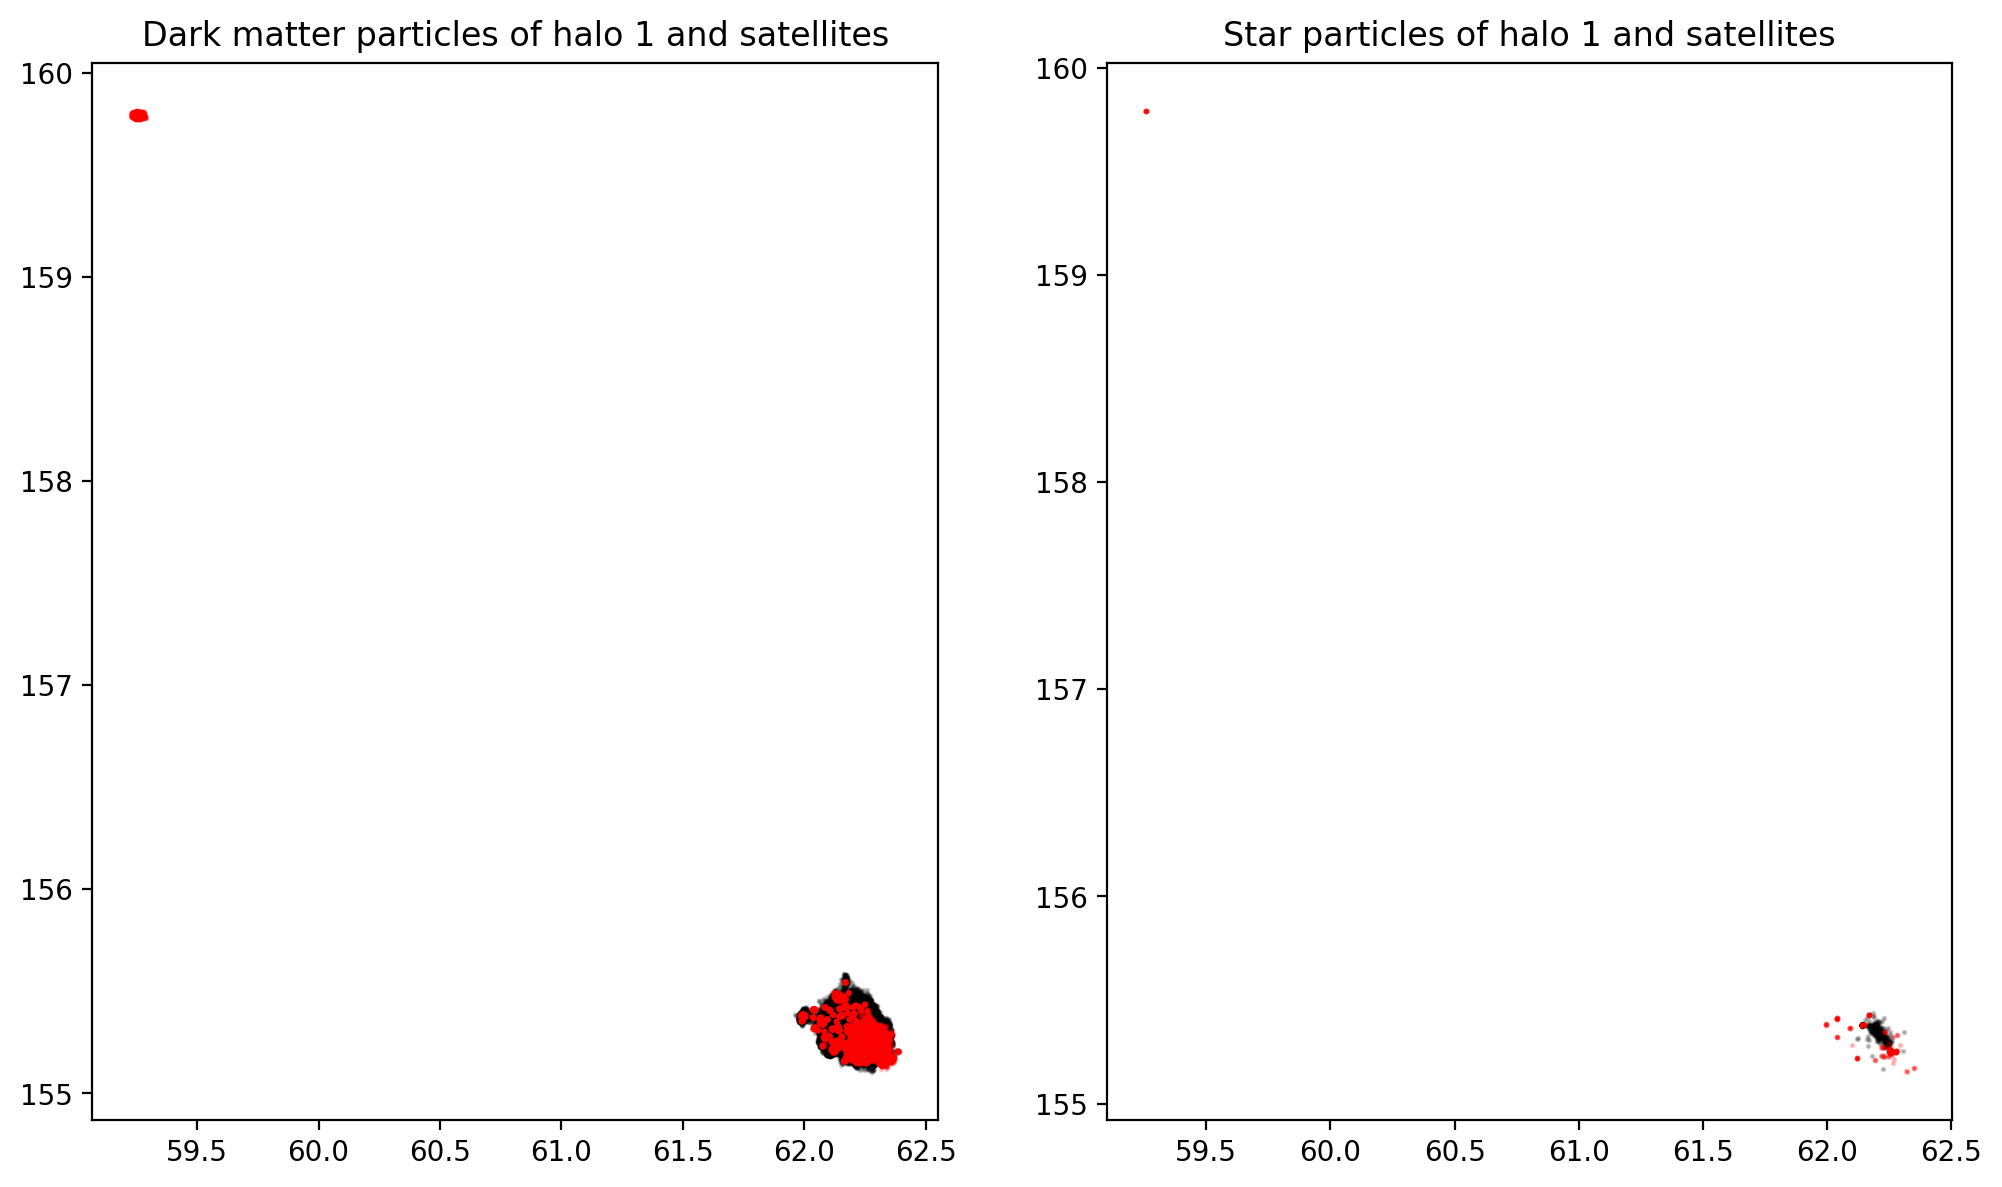

In [123]:
plot_particles(0)

Number of satellites 107


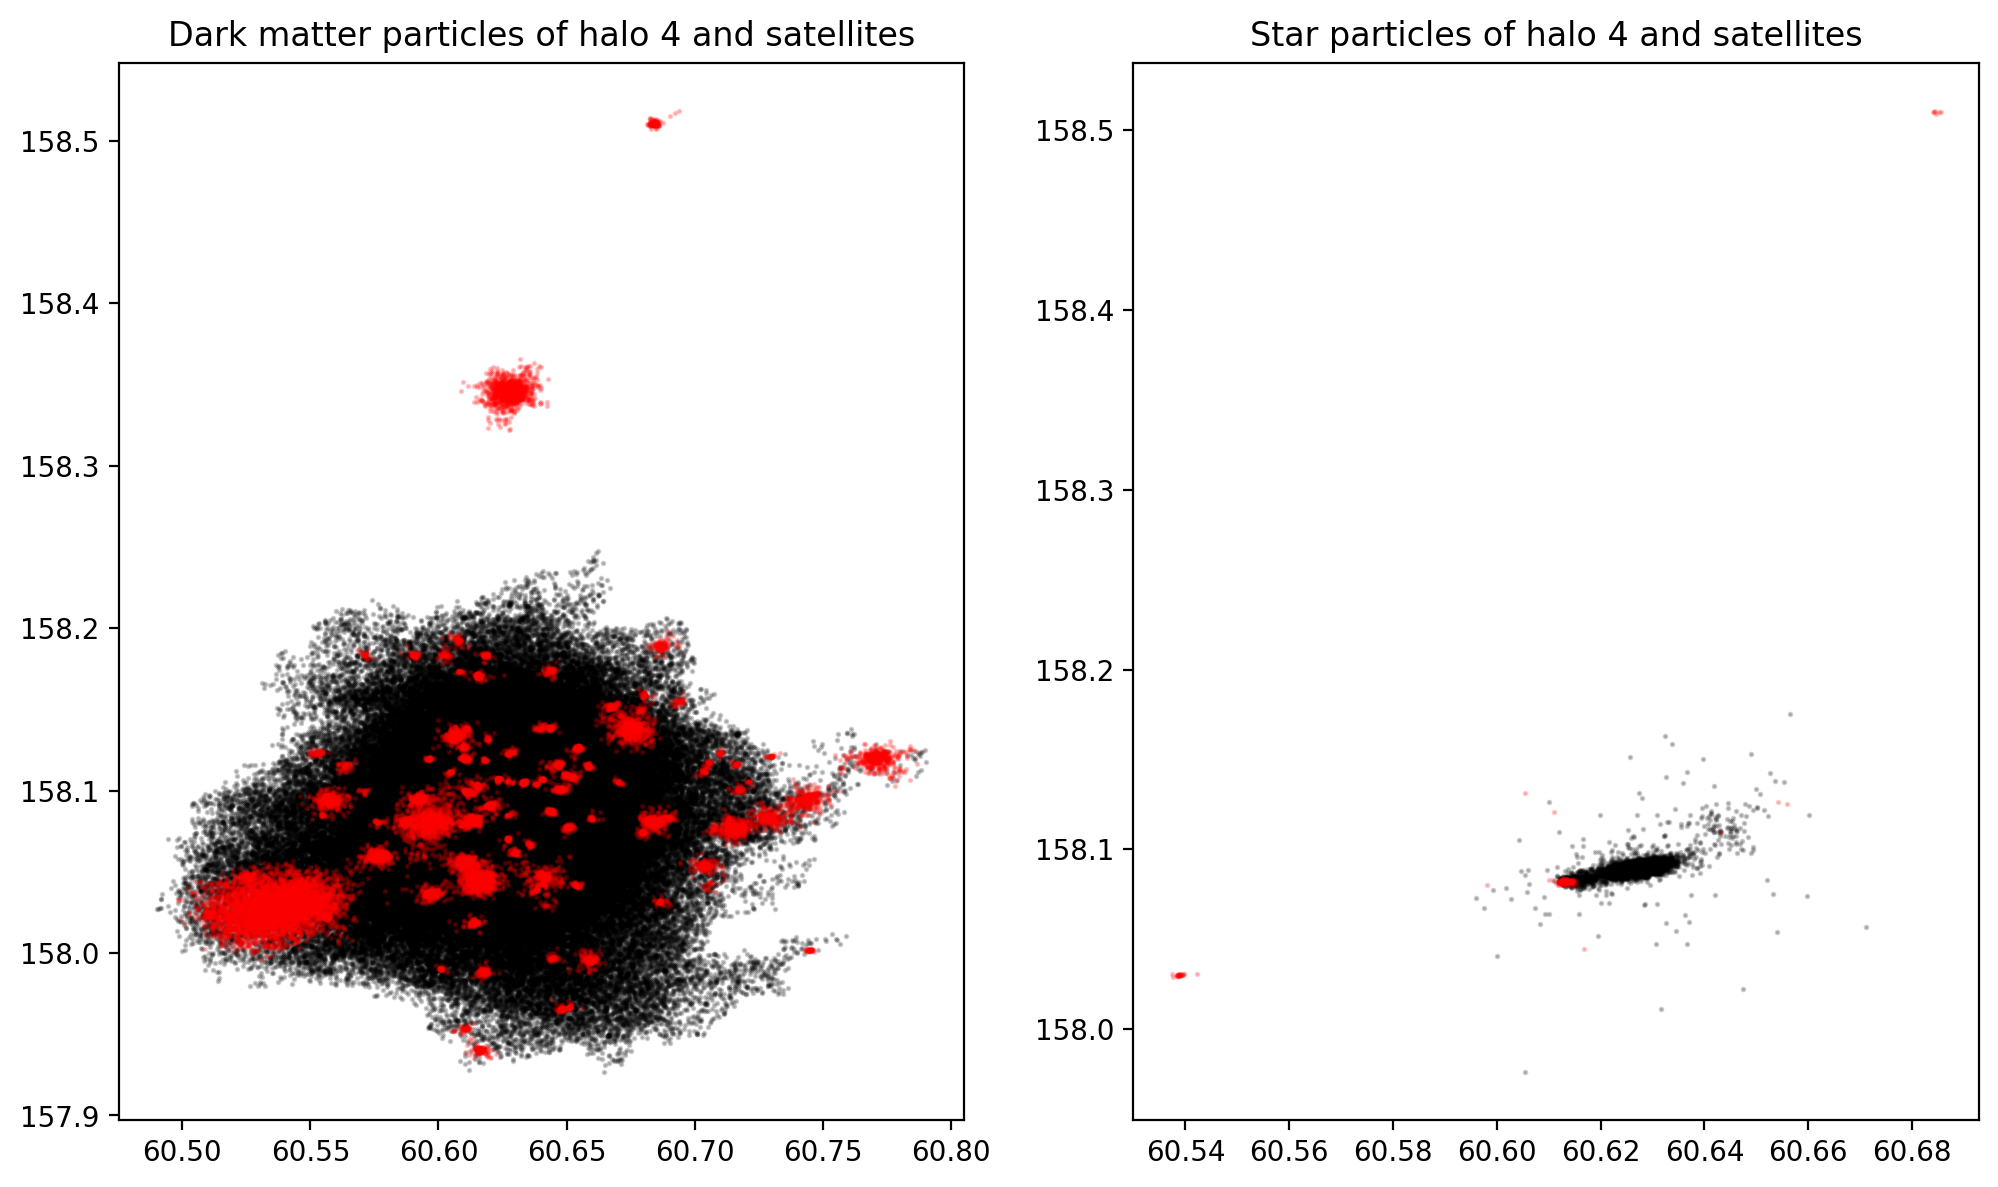

In [122]:
plot_particles(3)

Number of satellites 50


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


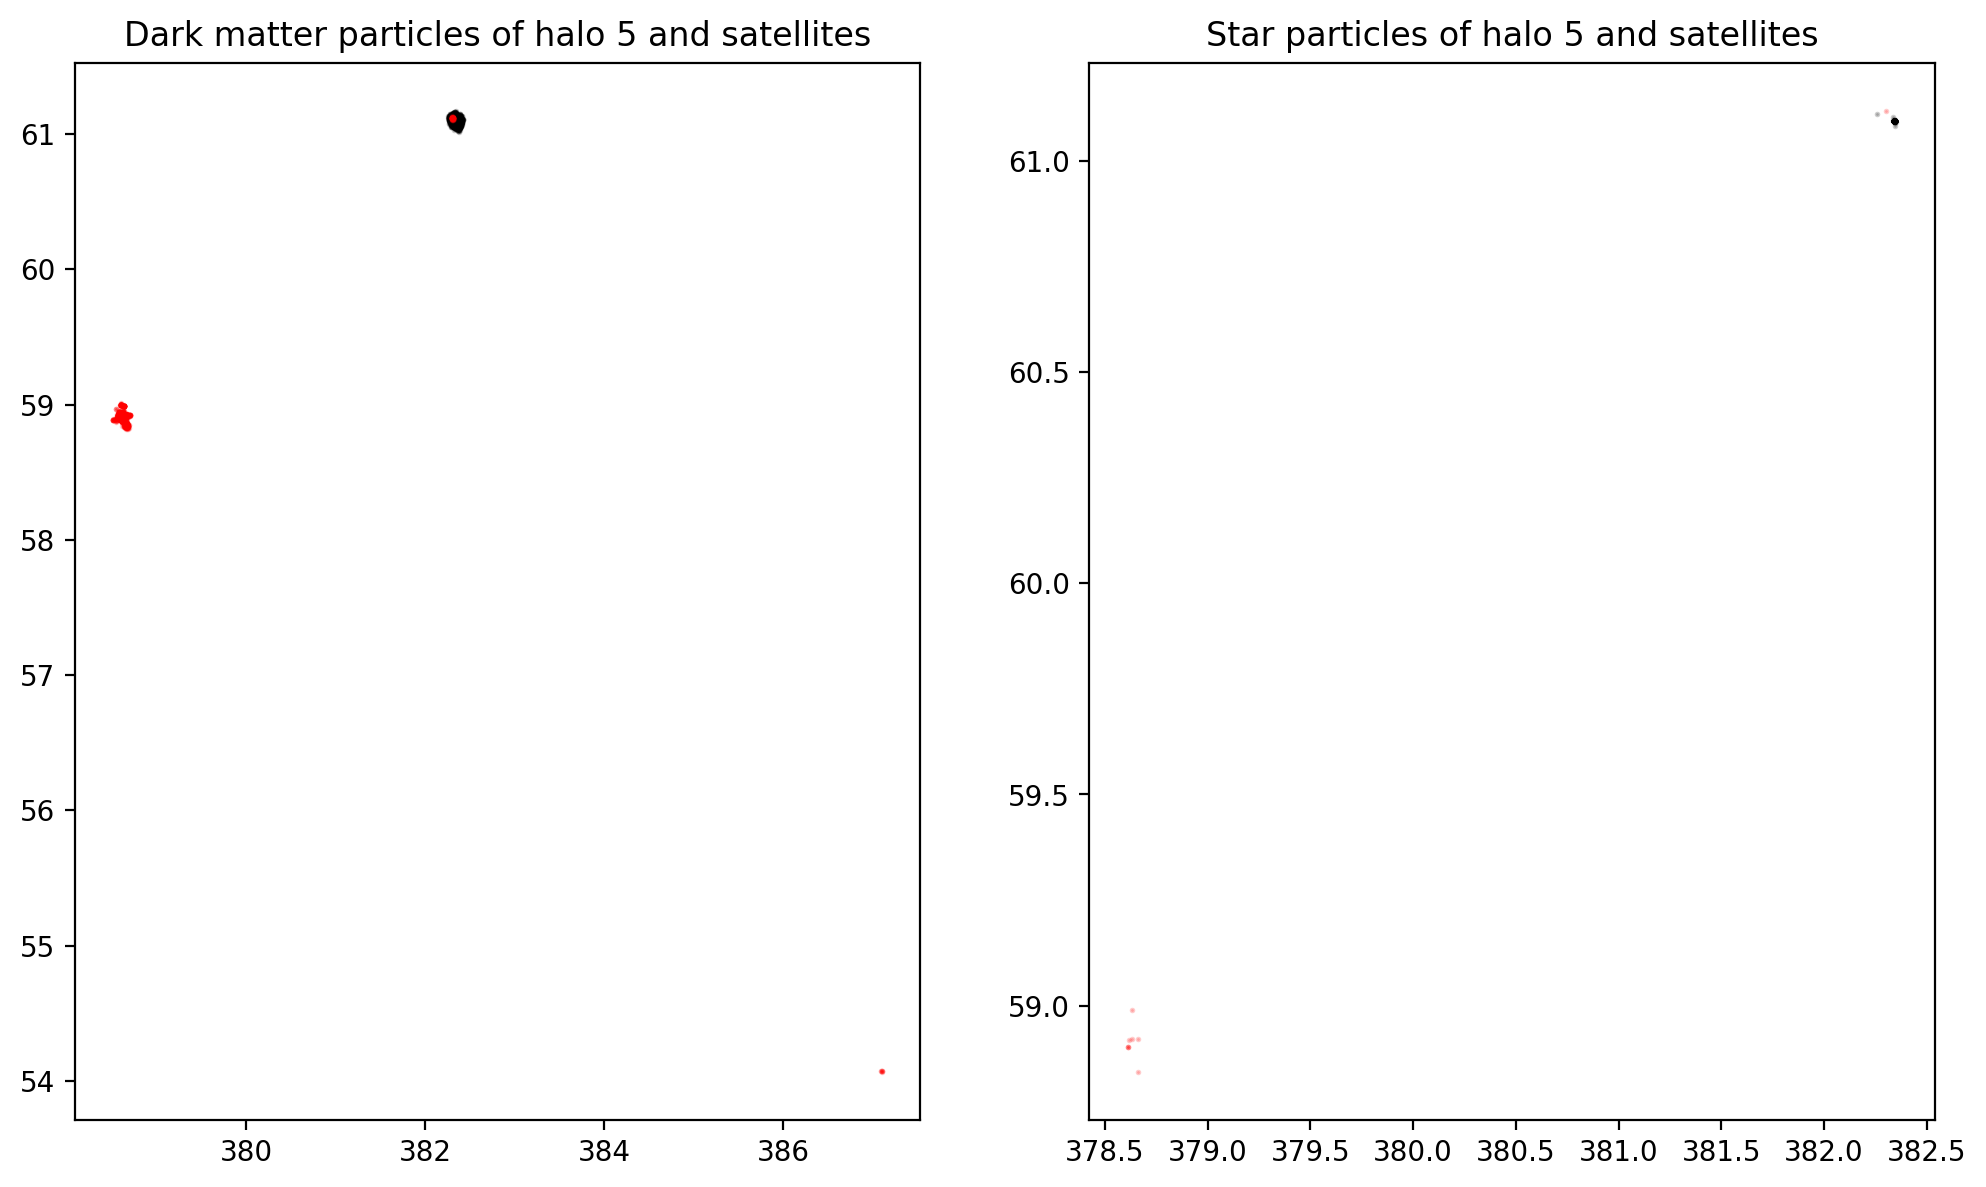

In [25]:
plot_particles(4)

## Get stellar mass vs. distance to host

In [8]:
#find the centers of the satellite halos
#get units?

def satellite_mass_distributions(which_host):

    #get stellar mass
    total_mass = np.array(soap['BoundSubhaloProperties/TotalMass'])[field==massive_halo_ids[which_host]]
    stellar_mass = np.array(soap['BoundSubhaloProperties/StellarMass'])[field==massive_halo_ids[which_host]]
    fig, [ax1, ax2] = plt.subplots(1, 2, dpi=150, figsize=(10,5))
    ax1.hist(np.log(np.ma.array(total_mass[field==massive_halo_ids[which_host]])), label='DM mass', histtype='step')
    ax2.hist(np.log(np.ma.array(mstar[field==massive_halo_ids[which_host]])), label='Stellar mass', histtype='step')
    ax1.set_title('Total distribution')
    ax2.set_title('M* distribution')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    #fig.legend()
    fig.show()

In [9]:
#plot total mass vs. distance to host
prop_file = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/halo_0063.properties.0'
prop = h5py.File(prop_file, 'r')
rvir = np.array(prop['Rvir'])*1000

def satellite_distance(which_host):
    sat_ids = halo_ids[field==massive_halo_ids[which_host]]
    host_center = soap['BoundSubhaloProperties/CentreOfMass'][which_host]
    satellite_centers = np.array(soap['BoundSubhaloProperties/CentreOfMass'][sat_ids-1])
    distances = np.array([np.linalg.norm(sat-host_center) for sat in satellite_centers])*1000 #inkpc
    return distances
    
def satellite_distance_distribution(which_host):
    #calculate distances
    distances = satellite_distance(which_host)
    #get total mass
    total_mass = np.array(soap['BoundSubhaloProperties/TotalMass'])[field==massive_halo_ids[which_host]]
    
    #sort by distance
    asc_dist = np.argsort(distances)
    
    #plot
    plt.figure(dpi=200)
    plt.scatter(distances[asc_dist], total_mass[asc_dist], s=5) #get actual kpc units from file
    idx = int(massive_halo_ids[which_host]-1)
    #plt.vlines(calc_r200(idx), 0, 1e10, 'r','--', label = 'Virial radius')
    plt.legend()
    plt.xlabel('Distance from host (center of mass) (kpc)')
    plt.ylabel(r'Total mass ($M_\odot$)')
    plt.yscale('log')
    plt.xscale('log')
    plt.suptitle(f'Distance of satellites of Halo {which_host+1} from host')
    plt.show()

No handles with labels found to put in legend.


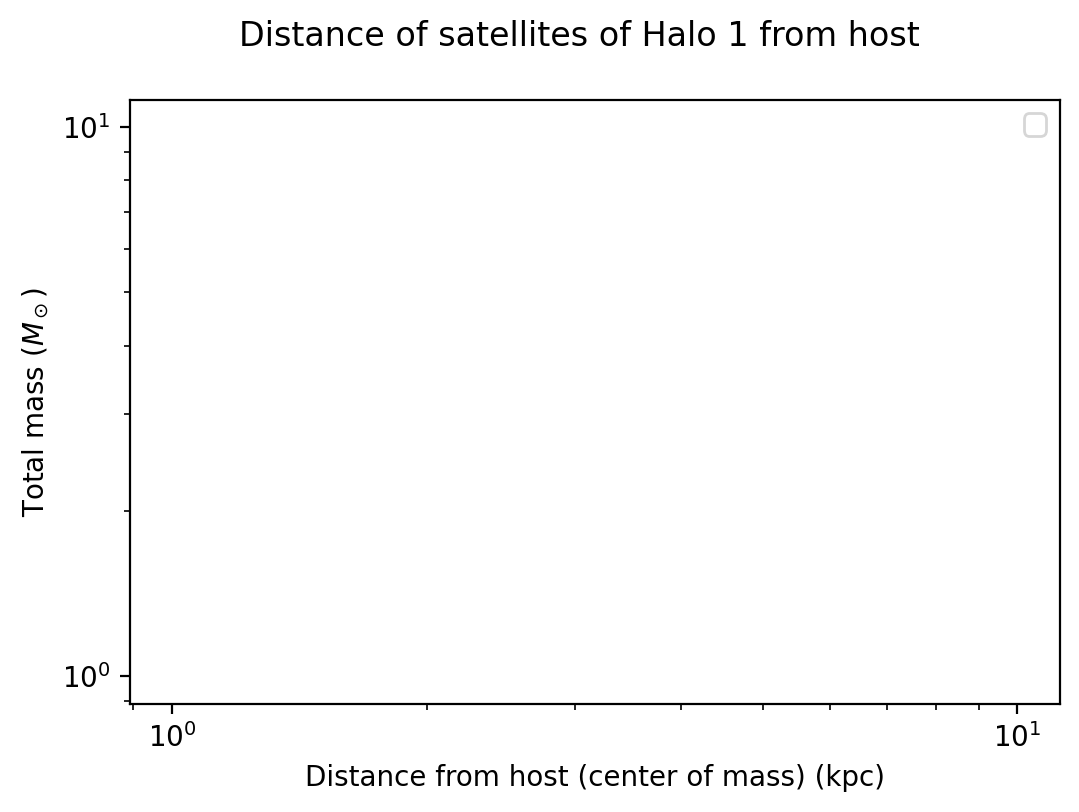

No handles with labels found to put in legend.


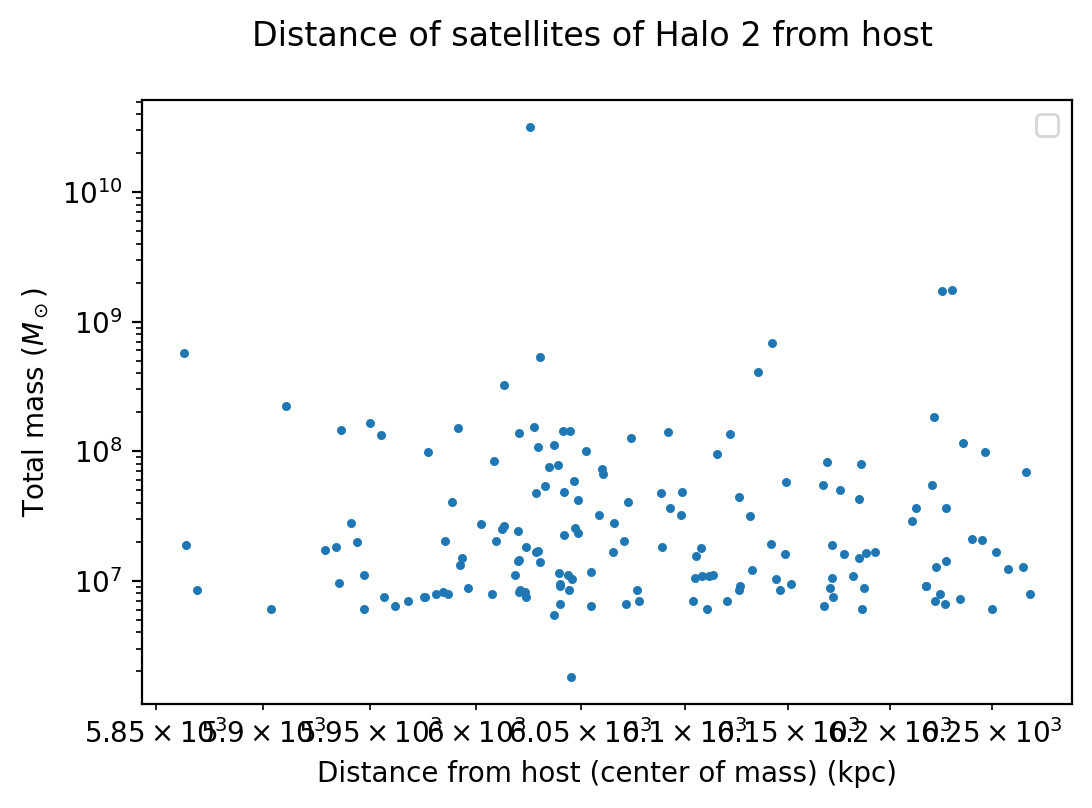

No handles with labels found to put in legend.


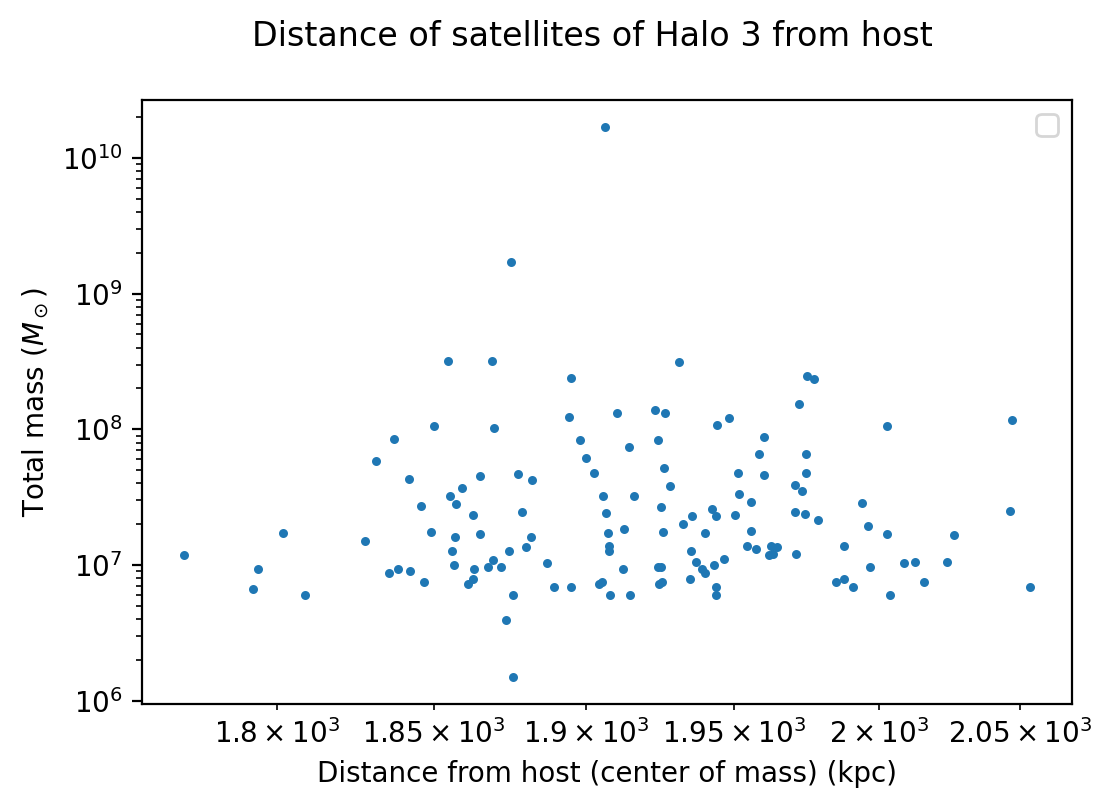

No handles with labels found to put in legend.


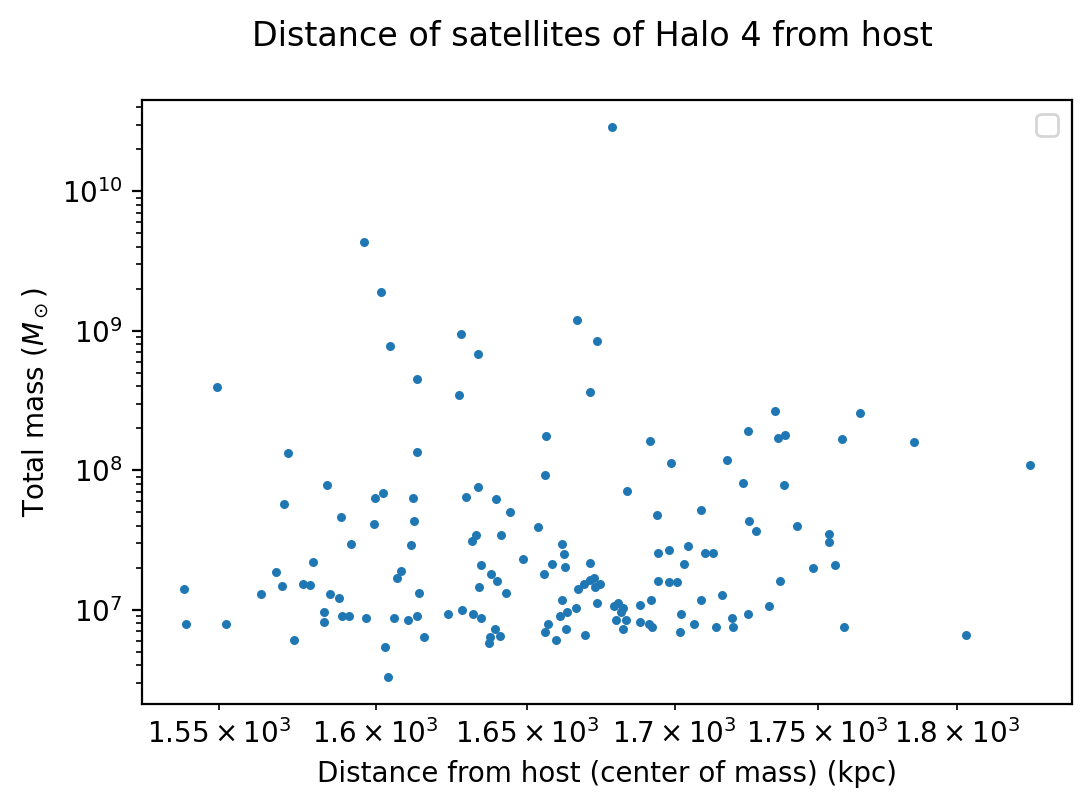

No handles with labels found to put in legend.


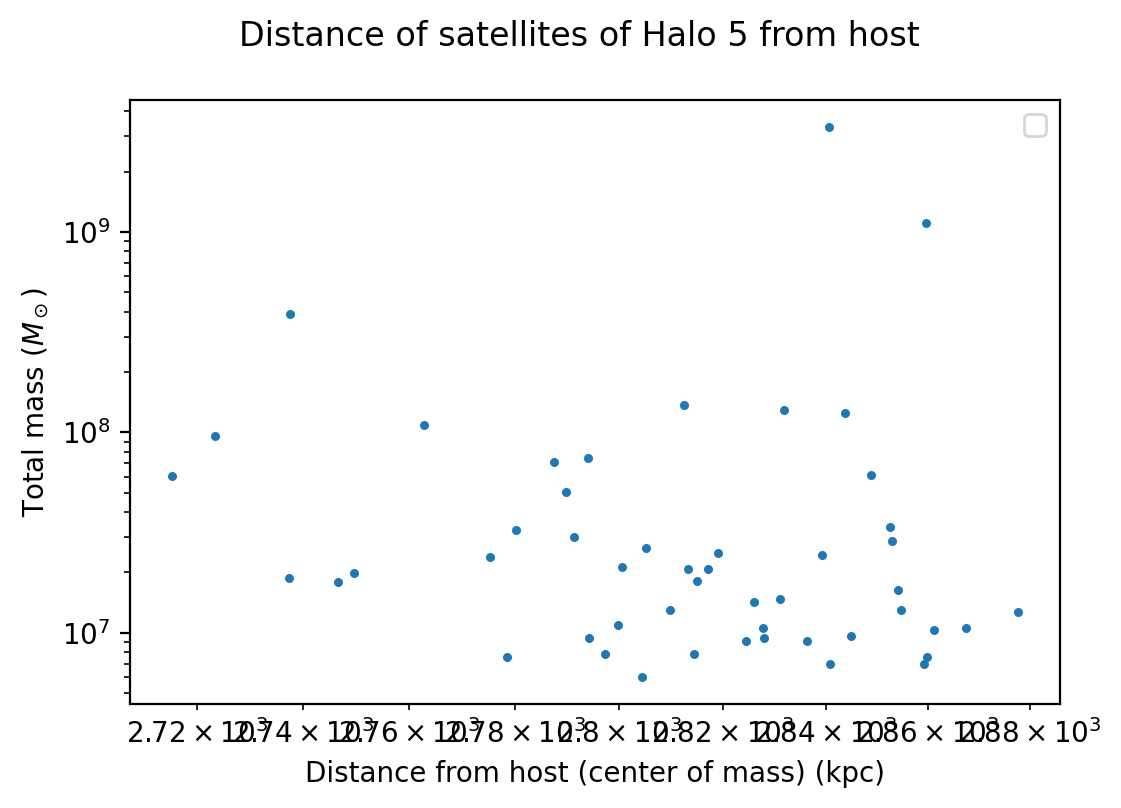

In [10]:
satellite_distance_distribution(0)
satellite_distance_distribution(1)
satellite_distance_distribution(2)
satellite_distance_distribution(3)
satellite_distance_distribution(4)

## Suggested explorations for LMC objects:
- Star formation histories (easy)
- Stellar Mass function (easy)
- Baryonic component of LMCs
    - Gas rich? Rotating?
    - Metallicity

In [398]:
#print(soap['SO/200_crit'].keys())

In [397]:
#Get velocity dispersion information from the simulations
#np.array(soap['BoundSubhaloProperties/StellarVelocityDispersionMatrix'])[which_host]
#np.array(soap['BoundSubhaloProperties/StellarVelocityDispersionMatrix'])[sat_ids]

In [28]:
m200 = np.array(soap['SO/200_crit/TotalMass'])
def calc_r200(which_host):
    m200 = np.array(soap['SO/200_crit/TotalMass'])[which_host] #mass is in solar mass
    with open('/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/halo_0063.siminfo', 'r') as f:
        lines = f.readlines()
    for line in lines:
        if 'h_val' in line:
            parts = line.split()
            h_val = float(parts[2])
            break
    H = h_val*100 #converting from H/100 to h
    G = 4.3e-9 #converting from pc to Mpc
    rho_crit = 3*(H**2)/(8*np.pi*G)
    r200 = (m200/(4/3. * np.pi * 200*rho_crit))**(1/3)*1000
    return r200

for i in [2, 3, 10]:
    print('halo no. ', i, 'halo mass (1e9 Msol)', m200[i]/1e9, ' r200 (kpc)', calc_r200(i))

halo no.  2 halo mass (1e9 Msol) 167.484899328  r200 (kpc) 115.80215181040522
halo no.  3 halo mass (1e9 Msol) 101.381947392  r200 (kpc) 97.95913772045445
halo no.  10 halo mass (1e9 Msol) 34.86558208  r200 (kpc) 68.63153578208022


KeyError: "Unable to open object (object 'CentreOfPotential' doesn't exist)"

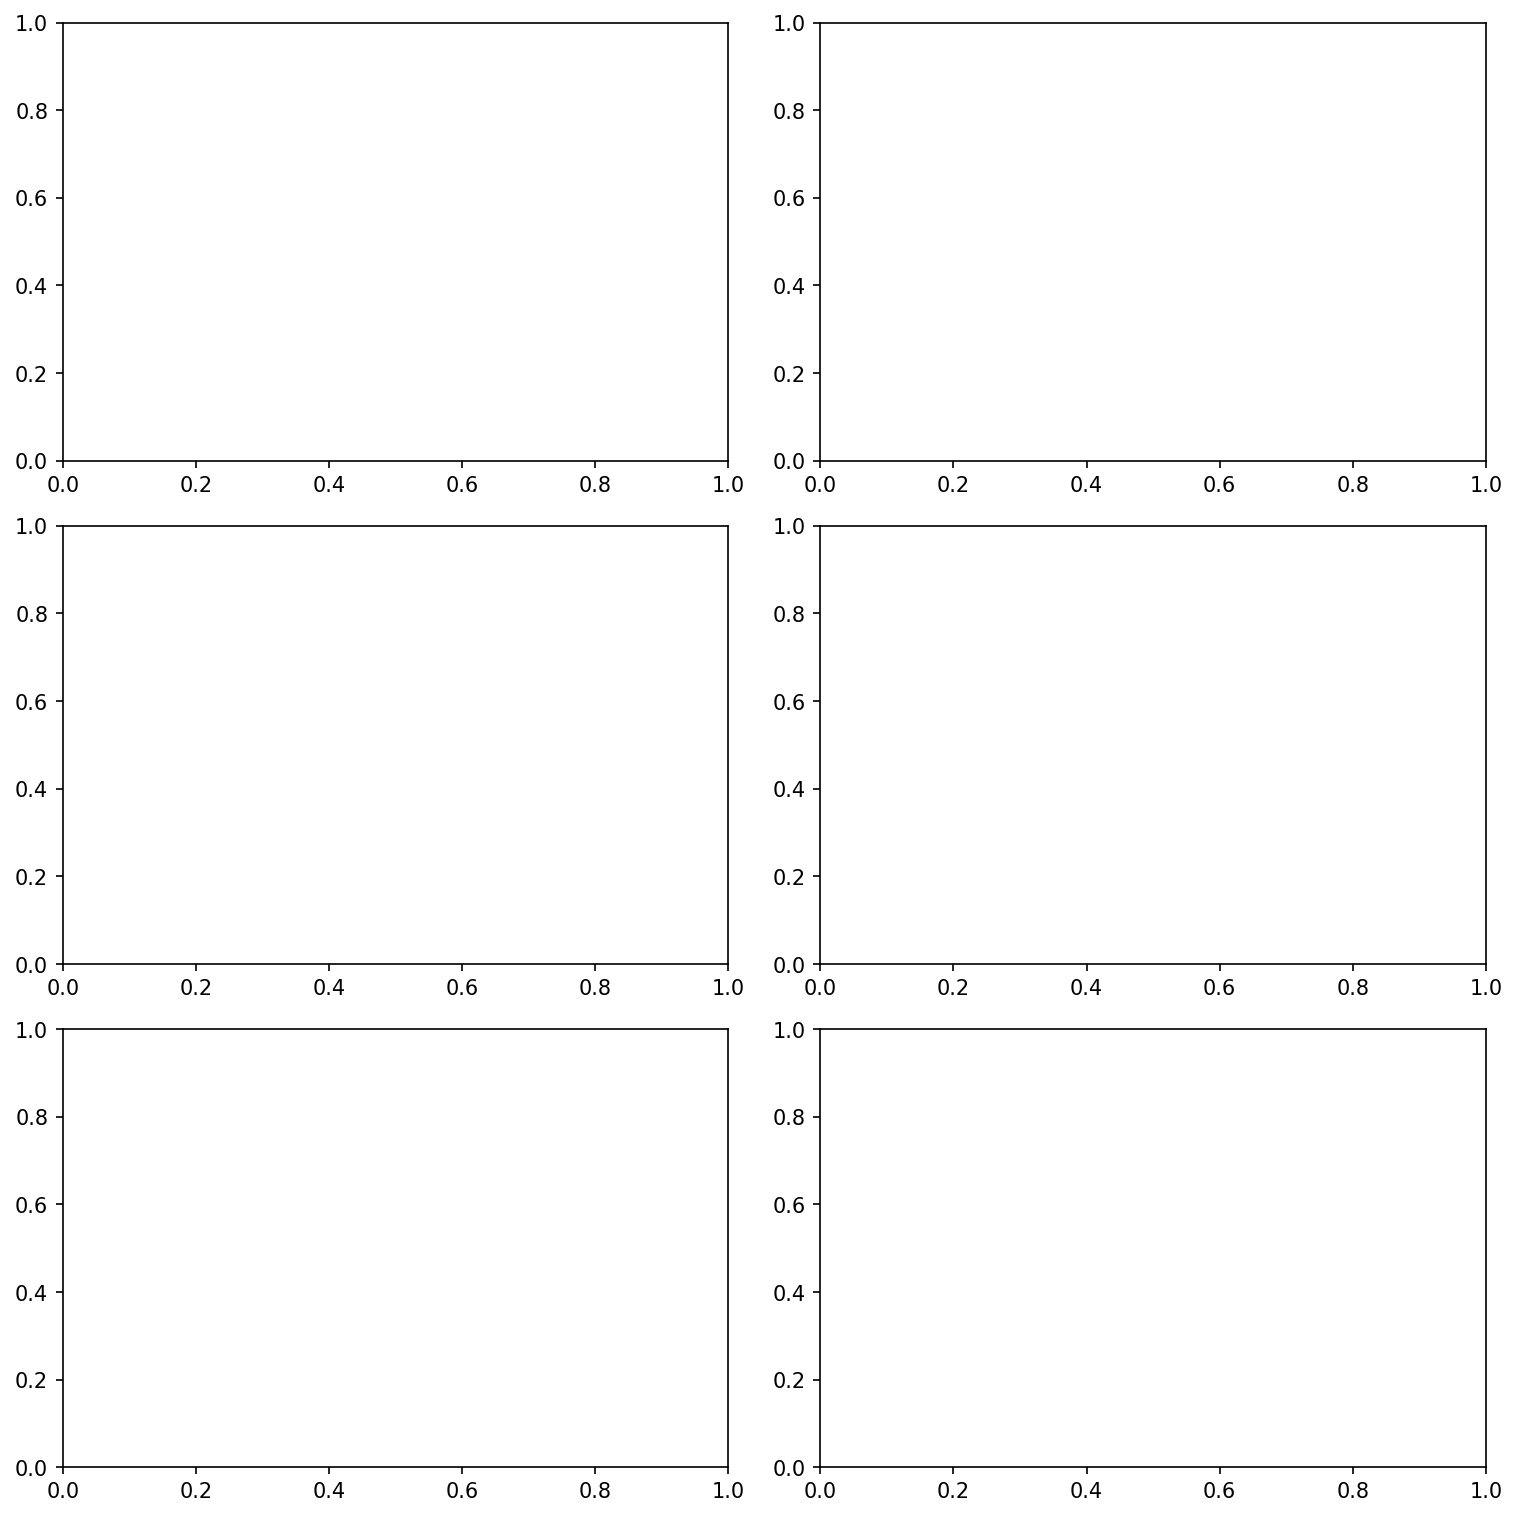

In [29]:
def number_plots(host_indices):
    fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
    ax_flat = ax.flatten()

    for which_host in host_indices:
        r200 = calc_r200(which_host)
        sat_ids = halo_ids[field == halo_ids[which_host]]
        host_center = soap['BoundSubhaloProperties/CentreOfMass'][which_host]
        satellite_centers = np.array(soap['BoundSubhaloProperties/CentreOfMass'][sat_ids-1])
        distances = np.array([np.linalg.norm(sat - host_center) for sat in satellite_centers]) * 1000
        new_sat_ids = sat_ids[distances < r200] - 1
        new_sat_ids = new_sat_ids[mtotal[new_sat_ids] > 1e8]
        distances = distances[distances < r200]
        arrays = {'distance': distances,
                  'distance_norm': distances / r200,
                  'mstar': mstar[new_sat_ids], 
                  'mtotal': mtotal[new_sat_ids], 
                  'mstar_norm': mstar[new_sat_ids] / mstar[halo_ids[which_host]], 
                  'mtotal_norm': mtotal[new_sat_ids] / mtotal[halo_ids[which_host]]
                 }

        # Loop over the first 6 keys in the arrays dictionary
        for i, key in enumerate(list(arrays.keys())[:6]):
            # Get the x values and sort them in reverse order
            x_values = sorted(arrays[key], reverse=True)

            # Determine y values
            if key == 'distance' or key == 'distance_norm':
                y_values = np.linspace(len(x_values) + 1, 1, len(x_values))
            else:
                ax_flat[i].set_xscale('log')
                y_values = np.arange(1, len(x_values) + 1)

            # Plot the values with a label for the host index
            ax_flat[i].plot(x_values, y_values, '-', label=f'Host {which_host}')
            ax_flat[i].set_title(key)
            ax_flat[i].legend()

    ax_flat[0].set_xlabel('r (kpc)')
    ax_flat[0].set_ylabel('N(<r)')
    
    ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
    ax_flat[1].set_ylabel('N(<r)')
    
    ax_flat[2].set_xlabel(r'M* ($M_\odot$)')
    ax_flat[2].set_ylabel('N(<M*)')
    ax_flat[2].set_yscale('log')
    
    ax_flat[3].set_xlabel(r'$M_{tot}$ ($M_{\odot}$)')
    ax_flat[3].set_ylabel('$N(<M_{tot})$')
    ax_flat[3].set_yscale('log')
    
    ax_flat[4].set_xlabel(r'$M*/M*_{host}$ ($M_{\odot}$)')
    ax_flat[4].set_ylabel('$N(<M*/M*_{host})$')
    ax_flat[4].set_yscale('log')
    
    ax_flat[5].set_xlabel(r'$M_{tot}/M_{tot} host$ ($M_{\odot}$)')
    ax_flat[5].set_ylabel(r'N(<$M_{tot}/M_{tot} host$)')
    ax_flat[5].set_yscale('log')
    
    fig.suptitle('Central halo satellite properties')
    
    plt.show()

# Usage example:
number_plots(np.array([ 2, 3, 10]))


In [21]:
# see biggest objects to look at satellites (smaller ones won't have satellites) (LMC, stellar mass 10^9) how can we get satellites?

# volume 15 might have larger objects

#particle type 4 is stars

#particles type 0 is gas

#type 1 is DM, type 2 is background DM (low res)

#SANITY CHECK: plot stellar mass (mstar and/or total mass) vs distance to host once satellites are found. Distance should not be more than 100-200kpc

#Velocity dispersion in stars (part type 4, so 6 columns one for each part type)
#dispersion is total over every direction